### Mi primer AutoEncoder Variacional con Keras

En este notebook vamos a ver cómo podemos implementar un autoencoder variacional paso a paso. Todos los ejemplos están extraídos del propio blog de Keras, aquí tenéis el [enlace](https://blog.keras.io/building-autoencoders-in-keras.html) para su consulta. También he extraído imágenes e información de [este](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73) y [este](http://www.cs.us.es/~fsancho/?e=232) enlace que os dejo para vuestra consulta. Y [este](https://www.jeremyjordan.me/variational-autoencoders/) por si queréis ampliar con algo "más matemático".

Comenzemos recordando qué es un autoencoder variacional. Para ello, mirad la imagen siguiente:

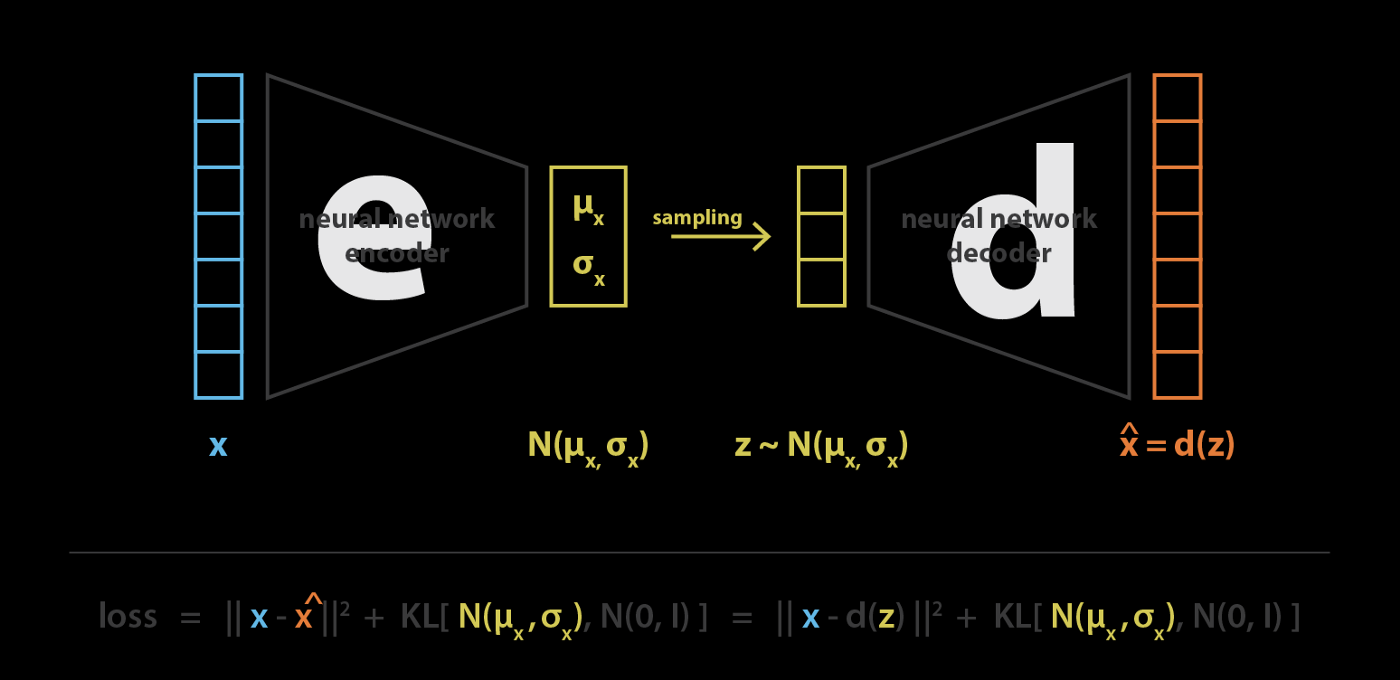

En ella podemos observar como, al igual que el autoencoder básico, consta de dos bloques: el encoder y el decoder. 

Por una parte, el **encoder** toma los datos de entrada y los comprime en una representación mucho más compacta. 

Por la otra, el **decoder** coge esa representación (o codificación) comprimida y trata de reconstruir los datos originales con el menor error posible.

La única diferencia es que el encoder, en este caso, no produce un "punto" en el espacio reducido, sino que produce una distribución de probabilidad. Es mediante el muestreo de esta distribución de probabilidad como somos capaces de regenerar los datos de entrada al introducirle la muestra obtenida al decoder.

A lo largo de esta práctica haremos lo siguiente:

* Empezaremos con un AutoEncoder Variacional muy simple, en el que tanto el encoder como el decoder tendrán una sola capa Densa.


**¡Comenzemos!**

Vamos a construir el AutoEncoder Variacional más simple posible:

In [ ]:
import keras
from keras import layers

original_dim = 28 * 28
intermediate_dim = 64
latent_dim = 2

inputs = keras.Input(shape=(original_dim,))
h = layers.Dense(intermediate_dim, activation='relu')(inputs)
z_mean = layers.Dense(latent_dim)(h)
z_log_sigma = layers.Dense(latent_dim)(h)


In [ ]:
from keras import backend as K

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=0.1)
    return z_mean + K.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])

In [ ]:
# Create encoder
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z], name='encoder')

# Create decoder
latent_inputs = keras.Input(shape=(latent_dim,), name='z_sampling')
x = layers.Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = layers.Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs, name='vae_mlp')

In [ ]:
reconstruction_loss = keras.losses.binary_crossentropy(inputs, outputs)
reconstruction_loss *= original_dim
kl_loss = 1 + z_log_sigma - K.square(z_mean) - K.exp(z_log_sigma)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

In [ ]:
import numpy as np
from keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

vae.fit(x_train, x_train,
        epochs=100,
        batch_size=32,
        validation_data=(x_test, x_test))

In [ ]:
import matplotlib.pyplot as plt

x_test_encoded = encoder.predict(x_test, batch_size=32)

In [ ]:
x_test_encoded = np.asarray(x_test_encoded)

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[2, :, 0], x_test_encoded[2, :, 1], c=y_test)
plt.colorbar()
plt.show()

In [ ]:
# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# We will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure)
plt.show()

Y con esto, tenemos nuestro primer VAE implementado.